# Capstone Project - The Battle of the Suburbs in Canberra
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

Canberra, the capital city of Australia, is often known as "The Bush Capital" to Aussies (and yes, we put that on our vehicle number plates). It is nothing like the usual metropolis like Madrid or Beijing which you would expect from other countries. It is an entirely planned garden-like city and in recent years, Canberra has been ranked among the world's best cities to live. As per 2021, there are about 430 thousands residents living accross the 814 square kilometeres region and the poupulation density of Canberra is only about 528/km2. This figure is not only low compared to other capital cities around the world but also only ranks 6 among all the 8 Australia capitals.

However for any new settlers in Canberra, it could be a bit hard at the begining to find the right area to live in. Canberra has a total of more than 100 local suburbs and 7 districts (or town centers as Canberrans refere to) and most of the facities, entertaiments and large shopping centers are located in these town centers. And if you ask any Canberran for suggestions about the using the public transport system to travel between these suburbs or town centers, he/she propaly would recommend you to get a car as the first thing after you find an accommadation. The rental cost or property price among these suburbs can also differ to a large extent based on their locations.

Assume that we have a young family who just moved from interstates or overseas and would like to purchase a 3 or 4 bedrooms house in Canberra to settle down. They set a budget for thier property hunting. What would be the best suburbs that they should look into in terms of propety price, travel distance to town centers etc. In this study, I will try to find the answer for them using the data science skills that I have acquired during the courses.

## Data <a name="data"></a>

First, I set out the required dataset in order to characterise the suburbs. As the choice of the interesting suburb to purchase property is mainly based on real estate price and convenience to local facilities, I will try to gather the median price for 3/4 bedrooms in each suburb, distance of each suburb to its nearest town centers and the number and type of venues close to each suburb.

I will exercise different methods from webscraping to open datasets to collect the requred data for my analysis:

* For the list of town centers and suburbs in Canberra, I will use webscrping to extract relevant fileds from the table found in the Wikipedia page [List of Canberra Suburbs](https://en.wikipedia.org/wiki/List_of_Canberra_suburbs)

* The latitude and longitude of town centers and suburbs will be retrieved using the geocoder library, after which the distance from suburb to town center can be calculated using the [Google Distance Matrix API](https://developers.google.com/maps/documentation/distance-matrix) or the Python [Haversine](https://pypi.org/project/haversine/) library.
* The number and type of venues around each suburb will be retrieved by calling the Forsquare APIs covered in this course.
* The median price for 3- or 4-bedroom houses will be scraped from [Domain's suburb profile](https://www.domain.com.au/suburb-profile/) page.

Steps to retrive these data will be explained in more details below but first let us import some of the commonly used Python libraries.

In [64]:
import numpy as np # library to handle data in a vectorized manner
import matplotlib.pyplot as plt

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import seaborn as sns

from scipy.spatial.distance import cdist

import json # library to handle JSON files

#!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from bs4 import BeautifulSoup
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!pip install folium=0.5.0|
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


### Get towncenter and suburbs

First we need to get a list of town centers and suburbs which belong to it. It turns out that this dataset is not easily to be found online in a nicly formated form like .csv or spreadsheet. So we go to the Wikipedia page of [Suburbs of Canberra](https://en.wikipedia.org/wiki/Suburbs_of_Canberra) and retrieve the data from the bottom tables:

In [2]:
url = "https://en.wikipedia.org/wiki/Suburbs_of_Canberra"
data = requests.get(url).text
soup = BeautifulSoup(data, 'html.parser')
for table in soup.find_all('table'):
    print(table.get('class'))

['box-Unreferenced_section', 'plainlinks', 'metadata', 'ambox', 'ambox-content', 'ambox-Unreferenced']
['wikitable']
['nowraplinks', 'mw-collapsible', 'autocollapse', 'navbox-inner']
['nowraplinks', 'mw-collapsible', 'mw-collapsed', 'navbox-subgroup']
['nowraplinks', 'navbox-subgroup']
['nowraplinks', 'navbox-subgroup']
['nowraplinks', 'mw-collapsible', 'mw-collapsed', 'navbox-subgroup']
['nowraplinks', 'navbox-subgroup']
['nowraplinks', 'hlist', 'mw-collapsible', 'autocollapse', 'navbox-inner']
['nowraplinks', 'hlist', 'mw-collapsible', 'autocollapse', 'navbox-inner']
['nowraplinks', 'hlist', 'mw-collapsible', 'autocollapse', 'navbox-inner']
['nowraplinks', 'hlist', 'mw-collapsible', 'autocollapse', 'navbox-inner']
['nowraplinks', 'hlist', 'mw-collapsible', 'autocollapse', 'navbox-inner']
['nowraplinks', 'hlist', 'mw-collapsible', 'autocollapse', 'navbox-inner']
['nowraplinks', 'hlist', 'mw-collapsible', 'autocollapse', 'navbox-inner']
['nowraplinks', 'hlist', 'mw-collapsible', 'autoc

A small challenge here is that those foldable tabels are nested and therefore same information may occure at different hierachy levels. After an cross examination between the webpage and the html inspector, I am able to narrow down the innerest talbe that containing the list of suburbs together with their corresponding town centers:

![Table of Canberra suburbs](figures/canberra_suburbs_wiki.png)

In [8]:
tables = soup.find_all('table',  {'class': ['nowraplinks'] and ['navbox-subgroup']})
table_can = tables[1]

For Belconnen to Woden Valley, each `tr` element has a `th` tag which includes the _Towncenter_ name and a `td` tag which includes an unordered list `ul` tag consisting of its suburbs.

![table element](figures/canberra_suburbs_html.png)

Let's define a function to retrieve the towncenter and suburbs from a given row:

In [4]:
# Get towncenter and surburbs from each table row
def get_suburbs(trow):
    towncenter = trow.find('th').text
    suburbs = []
    for l in trow.find('td').find_all('li'):
        suburbs.append(l.text)

    return towncenter, suburbs

We would also like to separate the _Canberra Central_ district into _North Canberra_ and _South Canberra_ for our analysis. Therefore we skip the outer row for _Canberra Central_ and instead using inner rows corresponding to _North Canberra_ and _South Canberra_. Let's create a Pandas DataFrame to store the results:

In [5]:
# createing the data frame
df = pd.DataFrame(columns=['Towncenter', 'Suburbs'])

for row in table_can.tbody.find_all('tr'):
    if row.find('th').text == 'Canberra Central':
        pass
    else:
        towncenter, suburbs = get_suburbs(row)
        df = df.append({'Towncenter': towncenter, 'Suburbs': suburbs}, ignore_index=True)

df.head()

,Towncenter,Suburbs
0,North Canberra,"[Acton, Ainslie, Braddon, Campbell, City, Dick..."
1,South Canberra,"[Barton, Capital Hill, Deakin, Forrest, Fyshwi..."
2,Belconnen,"[Aranda, Belconnen, Bruce, Charnwood, Cook, Du..."
3,Gungahlin,"[Amaroo, Bonner, Casey, Crace, Forde, Franklin..."
4,Molonglo Valley,"[Coombs, Denman Prospect, Molonglo, Whitlam, W..."


Now seperate each suburb to individual rows and create a new Pandas DataFrame `df_can`. This will be our master DataFrame for the required datasets and will be updated as new information is added. Hereafter we store the `df_can` to individual .csv files at different stages. This will allow us to read the datasets from stored files instead of webscraping again for future runs should we wish (for speed or data consistancy concerns).

In [9]:
# convert suburb list elements to separate rows
# https://www.geeksforgeeks.org/convert-list-like-column-elements-to-separate-rows-in-pandas/
df_can = df['Suburbs'].apply(pd.Series) \
                    .merge(df, right_index=True, left_index=True) \
                    .drop(['Suburbs'], axis=1) \
                    .melt(id_vars=['Towncenter'], value_name='Suburb') \
                    .drop('variable', axis=1) \
                    .dropna()

df_can = df_can.sort_values('Suburb', ascending=True).reset_index(drop=True)
df_can.to_csv('data/canberra_suburbs.csv', index=False)
df_can.head()

,Towncenter,Suburb
0,North Canberra,Acton
1,North Canberra,Ainslie
2,Gungahlin,Amaroo
3,Belconnen,Aranda
4,Tuggeranong,Banks


### Add postcode

Although the post code for each suburb is not directly used in this analysis, it is necessary to collect them as we will use it later when scrap house price information. A FreeDatabase of Australian Postcodes can be found on [Matthew Proctor's website](https://www.matthewproctor.com/australian_postcodes). Let's download the dataset and read them into a Pandas DataFrame:

In [12]:
#df_can = pd.read_csv('data/canberra_suburbs.csv')
df_post = pd.read_csv('data/australian_postcodes.csv')
df_post_act = df_post[(df_post['state'] == 'ACT')][['postcode', 'locality']]
df_post_act.head()

,postcode,locality
0,200,ANU
1,200,Australian National University
3750,2540,HMAS CRESWELL
3755,2540,JERVIS BAY
4243,2600,BARTON


Next filter the postcode for Canberra suburbs and merge them into our previous `df_can` DataFrame:

In [11]:
df_can = pd.merge(df_can, df_post_act, left_on=df_can['Suburb'].str.upper(), right_on=df_post_act['locality'].str.upper(), how='left').fillna(0)
df_can.drop(['key_0', 'locality'], axis=1, inplace=True)
df_can.rename(columns={'postcode': 'Postcode'}, inplace=True)
df_can['Postcode'] = df_can['Postcode'].astype(int)
df_can = df_can.drop_duplicates(subset=['Suburb'], keep='first')
df_can.to_csv('data/canberra_suburbs_postcode.csv', index=False)
df_can.head()

,Towncenter,Suburb,Postcode
0,North Canberra,Acton,2601
1,North Canberra,Ainslie,2602
2,Gungahlin,Amaroo,2914
3,Belconnen,Aranda,2614
4,Tuggeranong,Banks,2906


### Add geo location

To get the latitude and longitude information for each suburb, let's use the `geopy` library demonstrated in previous labs:

In [13]:
from geopy.geocoders import Nominatim

In [21]:
#df_can = pd.read_csv('data/canberra_suburbs_postcode.csv')
geolocator = Nominatim(user_agent="act_agent")
print('Obtaining latitude and longitude: ', end='')
df_can['Latitude'] = 0.0
df_can['Longitude'] = 0.0
for index, row in df_can.iterrows():    
    address = '{}, ACT'.format(row['Suburb'])
    location = geolocator.geocode(address)
    #df_can['Latitude'][index] = location.latitude
    #df_can['Longitude'][index] = location.longitude
    df_can.loc[index, 'Latitude'] = location.latitude
    df_can.loc[index, 'Longitude'] = location.longitude
    print(' .', end='')

print(' done.')
df_can.to_csv('data/canberra_suburbs_geo.csv', index=False)
df_can.head()

Obtaining latitude and longitude:  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . done.


,Towncenter,Suburb,Postcode,Latitude,Longitude
0,North Canberra,Acton,2601,-35.285232,149.112968
1,North Canberra,Ainslie,2602,-35.262195,149.147880
2,Gungahlin,Amaroo,2914,-35.169587,149.128021
3,Belconnen,Aranda,2614,-35.258055,149.080426
4,Tuggeranong,Banks,2906,-35.471889,149.099657


#### Add towncenters

Let's create a seperate DataFrame `df_town` for the towncenters and their latitude and longitude information. First check if we have all the 8 towncenters included in our master DataFrame:

In [23]:
df_can['Towncenter'].unique()

array(['North Canberra', 'Gungahlin', 'Belconnen', 'Tuggeranong',
       'South Canberra', 'Weston Creek', 'Woden Valley',
       'Molonglo Valley'], dtype=object)

Looks all right. Now we use geocoder to populate the latitude and longitude for all the towncenters and store that to a .csv file too.

In [76]:
df_town = pd.DataFrame(columns=['Towncenter', 'Latitude', 'Longitude'])

for towncenter in df_can['Towncenter'].unique():
    address = '{}, ACT'.format(towncenter)
    location = geolocator.geocode(address)
    df_town = df_town.append({'Towncenter': towncenter, 'Latitude': location.latitude, 'Longitude': location.longitude}, ignore_index=True)
    
df_town.to_csv('data/canberra_towncenters.csv', index=False)    
df_town.head()

,Towncenter,Latitude,Longitude
0,North Canberra,-35.264383,149.132543
1,Gungahlin,-35.178878,149.123653
2,Belconnen,-35.227434,149.043145
3,Tuggeranong,-35.420977,149.092134
4,South Canberra,-35.316170,149.131307


#### Visualisation

Based on the geo information of all the suburbs and towncenters, I wanna visualize them on f Folium map to examine if the data make sense.

In [74]:
address = 'Canberra, ACT'

geolocator = Nominatim(user_agent="act_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Canberra are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Canberra are -35.2975906, 149.1012676.


In [28]:
# create map of Toronto using latitude and longitude values
map_canberra = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to suburbs
for lat, lng, towncenter, suburb in zip(df_can['Latitude'], df_can['Longitude'], df_can['Towncenter'], df_can['Suburb']):
    label = '{}, {}'.format(suburb, towncenter)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_canberra)  
    
# add markers to towncenters
for lat, lng, towncenter in zip(df_town['Latitude'], df_town['Longitude'], df_town['Towncenter']):
    label = '{}'.format(towncenter)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=30,
        popup=label,
        color='purple',
        fill=True,
        fill_color='#EDE3FF',
        fill_opacity=0.3,
        parse_html=False).add_to(map_canberra)
    
map_canberra

The visulization looks all right so let's proceed to the next step to calulate the distance of each suburb to its nearest towncenter.

### Driving distance to nearest Towncenter

My first attempt to calculate the driving distance between suburb to towncenter is to use [Google Distance Matrix API](https://developers.google.com/maps/documentation/distance-matrix/overview) following [this blog post](https://www.geeksforgeeks.org/python-calculate-distance-duration-two-places-using-google-distance-matrix-api/). Unfortunatly at the time of this study, there is no longer free options to use the Google Distance Matrix API. As an alternative, I will explore the [Haversine Distance](https://towardsdatascience.com/calculating-distance-between-two-geolocations-in-python-26ad3afe287b) as an alternative to the driving distance.


First let's create a DataFrame holding the matrix of suburb (row) and towncenter (column):

In [29]:
import haversine as hs

In [30]:
to_columns = [town for town in df_town['Towncenter']]
to_columns.append('Nearest')

df_to = pd.DataFrame(columns=['Suburb']+to_columns)
df_to['Suburb'] = df_can['Suburb']
df_to.head()

,Suburb,North Canberra,Gungahlin,Belconnen,Tuggeranong,South Canberra,Weston Creek,Woden Valley,Molonglo Valley,Nearest
0,Acton,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Ainslie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Amaroo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Aranda,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Banks,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now iterate each suburb and towncenter and calculate the Haversine Distance between them. An extra column `Nearest` hold the distance of a suburb to its closest towncenter which may not necessarily be the demographic one that it belongs to.

In [32]:
# Set towncenter and suburb as index for convenience
df_to = df_to.set_index('Suburb')
df_can = df_can.set_index('Suburb')
df_town = df_town.set_index('Towncenter')
for town in df_to.columns[:-1]:
    loc_town = (df_town.loc[town, 'Latitude'], df_town.loc[town, 'Longitude'])
    
    for sub in df_to.index.tolist():
        loc_sub = (df_can.loc[sub, 'Latitude'], df_can.loc[sub, 'Longitude'])
        dis = hs.haversine(loc_sub, loc_town)
        df_to.loc[sub, town] = dis
           
# Nearest distance to towncenter
df_to['Nearest'] = df_to[df_to.columns[:-1]].min(axis=1)
# reset index
df_to = df_to.reset_index()
df_can = df_can.reset_index()
df_town = df_town.reset_index()
df_to.head()

,Suburb,North Canberra,Gungahlin,Belconnen,Tuggeranong,South Canberra,Weston Creek,Woden Valley,Molonglo Valley,Nearest
0,Acton,2.92106,11.8658,9.02768,15.212,3.82149,8.76342,7.38827,7.57056,2.921057
1,Ainslie,1.41353,9.52225,10.2666,18.3655,6.18731,12.8069,10.9032,11.4413,1.413531
2,Amaroo,10.5488,1.1068,10.0425,28.1424,16.302,20.654,20.2812,17.3014,1.106799
3,Aranda,4.78395,9.64007,4.80166,18.1473,7.94267,9.9409,10.2827,6.7199,4.783948
4,Banks,23.2656,32.654,27.6612,5.70203,17.5513,15.0409,13.5788,19.5805,5.702031


Now we can add the nearest distance to towncenter information to our master DataFraem `df_can`:

In [33]:
df_can = pd.merge(df_can, df_to[['Suburb', 'Nearest']], left_on='Suburb', right_on='Suburb', how='inner').fillna(0)
df_can.to_csv('data/canberra_suburbs_distance.csv', index=False)
df_can.head()

,Suburb,Towncenter,Postcode,Latitude,Longitude,Nearest
0,Acton,North Canberra,2601,-35.285232,149.112968,2.921057
1,Ainslie,North Canberra,2602,-35.262195,149.147880,1.413531
2,Amaroo,Gungahlin,2914,-35.169587,149.128021,1.106799
3,Aranda,Belconnen,2614,-35.258055,149.080426,4.783948
4,Banks,Tuggeranong,2906,-35.471889,149.099657,5.702031


### Add median price

Again, the dataset for the real estate price for each suburb is not readily (or at least freely) available online. Domain provides a [suburb profile page](https://www.domain.com.au/suburb-profile/) where you can enter the name of a suburb and serch its profile which happens to include a Market trends table. For example, following figure shows the information [found in suburb _Banks_](https://www.domain.com.au/suburb-profile/banks-act-2906): 

![Banks market trends](figures/domain_price.png)

We are interested in the price for a 3 or 4 bedrooms house for the young family wanting to settle down in Canberra. A little bit of exploration on the URLs for each suburb reveals that the suffix part has a pattern of `suburb-name/act/postcoe` with special character in the suburb name like single quote or space being replaced by a `-` character. So we define the following function to scrap the price data for 3/4-bedroom house:

In [34]:
def get_median_price(suburb, postcode):
    suburb = suburb.replace(' ', '-').replace("'", "-")
    url = 'https://www.domain.com.au/suburb-profile/{}-act-{}'.format(suburb.lower(), postcode)

    data = requests.get(url).text
    soup = BeautifulSoup(data, 'html.parser')
    table = soup.find('table',  {'class': ['css-15dn4s8']})

    df = pd.DataFrame(columns=['Bedrooms', 'Type', 'Median Price'])
    try:
        for body in table.find_all('tbody'):
            for row in body.find_all('tr'):
                columns = row.find_all('td')

                if(columns != []):
                    bedrooms = columns[0].text.strip()
                    type_ = columns[1].text.strip()
                    price = columns[2].text.strip().replace("$", "")
                    # convert price to numeric values
                    if price == '-':
                        price = None
                    else:
                        price = float(price[:-1]) * (10e3 if price[-1] == 'm' else 1) # convert to float

                    df = df.append({'Bedrooms':bedrooms, 'Type': type_, 'Median Price': price}, ignore_index=True)
    except:
        df = None

    return df

It is worth to note that not all suburbs have this Market trends table as it is based on the sales data in the past 12 months. Additionaly even the table exists, it is not always to have the price for 3/4 bedroom house for the very same reason. We will need to take care of these exceptions during the webscraping proceess and later on we will handle the missing information for some suburbs.

In [36]:
#df_can = pd.read_csv('data/canberra_suburbs_distance.csv')
print('Obtaining house price: ', end='')
df_price = pd.DataFrame(columns=['Suburb', 'bed3', 'bed4', 'Median Price'])
df_price['Suburb'] = df_can['Suburb']

for index, row in df_can.iterrows():
    suburb = row['Suburb']
    postcode = row['Postcode']
    df = get_median_price(suburb, postcode)
    
    if df is not None:
        df['Bedrooms'] = df['Bedrooms'].astype(int)
        # 3 bedrooms house price
        try:
            # not working
            p = df[(df['Type']=='House') & (df['Bedrooms']==3)]['Median Price'].values[0]
            df_price['bed3'][index] = p
        except:
            pass
        
        # 4 bedrooms house price
        try:
            p = df[(df['Type']=='House') & (df['Bedrooms']==4)]['Median Price'].values[0]
            df_price['bed4'][index] = p
        except:
            pass

    print(' .', end='')

print(' done.')
df_price.head()

Obtaining house price:  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . done.


,Suburb,bed3,bed4,Median Price
0,Acton,NaN,NaN,NaN
1,Ainslie,11580,17010,NaN
2,Amaroo,649,803,NaN
3,Aranda,NaN,NaN,NaN
4,Banks,537,773,NaN


#### Fixing missing prices

Let's first check the number of suburbs that we didn't find a price for 3/4-bedroom houses as well as the number of thouse only has either 3 or 4-bedrooms:

In [51]:
no_bed3_and_bed4 = df_price['bed3'].isnull() & df_price['bed4'].isnull()
no_bed3 = df_price['bed3'].isnull() & df_price['bed4'].notnull()
no_bed4 = df_price['bed3'].notnull() & df_price['bed4'].isnull()
total = df_price.shape[0]

print('No price for both 3 and 4 bedrooms: {}, missing {:.2f}%'.format(no_bed3_and_bed4.sum(), 
                                                                    no_bed3_and_bed4.sum()*100/total))
print('No price for 3 bedrooms: {}, missing {:.2f}%'.format(no_bed3.sum(),
                                                          no_bed3.sum()*100/total))
print('No price for 4 bedrooms: {}, missing {:.2f}%'.format(no_bed4.sum(),
                                                           no_bed4.sum()*100/total))

No price for both 3 and 4 bedrooms: 31, missing 27.68%
No price for 3 bedrooms: 10, missing 8.93%
No price for 4 bedrooms: 9, missing 8.04%


The missing rates for only 3 or 4 bedrooms are below 10% whereas missing rate for both 3 and 4 bedrooms are even higher 28%. Instead of dumpping the rows with missing values or using the column mean to fill in the missing values directly which is likely to insert many same price values, we use the following strategy to fix the missing prices:

1. Assume the ratio for 4-bedroom and 3-bedroom price is similar in all the suburbs, calculate this ratio based on the average of suburbs which contain both values.
2. For the suburbs mising only one price, let's use the other price and the above average ratio to estimate the other missing price.
3. Finally for suburbs missing both prices, use the column mean respectively.

In [52]:
#1. calculate mean ration between 3 and 4 bedroom house price
df_p = df_price[df_price['bed3'].notnull() & df_price['bed4'].notnull()]
scale = (df_p['bed4'] / df_p['bed3']).mean()
#2. pupulating missing price using the mean scale based on the other existing price
df_price['bed4'][no_bed4] = df_price[no_bed4]['bed3'] * scale
df_price['bed3'][no_bed3] = df_price[no_bed3]['bed4'] / scale
#3. for those missing both 3&4 bedrooms, using the column mean
df_price['bed3'].fillna(value=df_price['bed3'].mean(), inplace=True)
df_price['bed4'].fillna(value=df_price['bed4'].mean(), inplace=True)
df_price.head()

,Suburb,bed3,bed4,Median Price
0,Acton,1880.696666,4208.770003,NaN
1,Ainslie,11580.000000,17010.000000,NaN
2,Amaroo,649.000000,803.000000,NaN
3,Aranda,1880.696666,4208.770003,NaN
4,Banks,537.000000,773.000000,NaN


Now calulate an average price for 3 and 4 bedrooms house and merge that information into our master DataFrame `df_can`:

In [53]:
df_price['Median Price'] = df_price[['bed3', 'bed4']].mean(axis=1)

df_can = df_can.merge(df_price[['Suburb', 'Median Price']], left_on='Suburb', right_on='Suburb', how='inner')
df_can.to_csv('data/canberra_suburbs_price.csv', index=False)
df_can.head()

,Suburb,Towncenter,Postcode,Latitude,Longitude,Nearest,Median Price
0,Acton,North Canberra,2601,-35.285232,149.112968,2.921057,3044.733334
1,Ainslie,North Canberra,2602,-35.262195,149.147880,1.413531,14295.000000
2,Amaroo,Gungahlin,2914,-35.169587,149.128021,1.106799,726.000000
3,Aranda,Belconnen,2614,-35.258055,149.080426,4.783948,3044.733334
4,Banks,Tuggeranong,2906,-35.471889,149.099657,5.702031,655.000000


### Use Foursquare to check venues

Similar to previous labs covered in the course, we will use the Foursquare API to explore the venues around each suburb and catagarize them. First define some credentials and a function to reteive venue information for a list of suburbs:

In [54]:
CLIENT_ID = 'NA1JN3DQJULNX1LDJ00TD14RADCEPYZDJ1KSZEHK1LMVATL1' # your Foursquare ID
CLIENT_SECRET = 'RWZA2UXX3T1CENZTGVAWJ11FQRXSKO3B50NLOCAPLBIZ0NJY' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

In [56]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    print('Obtaining venue information: ', end='')
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        print(' .', end='')

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Suburb', 
                  'Suburb Latitude', 
                  'Suburb Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    print(' done.')
    return(nearby_venues)

In [57]:
#df_can = pd.read_csv('data/canberra_suburbs_price.csv')
canberra_venues = getNearbyVenues(names=df_can['Suburb'],
                                latitudes=df_can['Latitude'],
                                longitudes=df_can['Longitude'],
                                radius=2000
                                )

Obtaining venue information:  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . done.


In [58]:
print('There are {} total categories.'.format(canberra_venues.shape[0]))
print('There are {} uniques categories.'.format(len(canberra_venues['Venue Category'].unique())))
canberra_venues.to_csv('data/canberra_venues.csv', index=False)
canberra_venues.head()

There are 3042 total categories.
There are 196 uniques categories.


,Suburb,Suburb Latitude,Suburb Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Acton,-35.285232,149.112968,Group Seven Espresso,-35.281864,149.124639,Coffee Shop
1,Acton,-35.285232,149.112968,Llewellyn Hall,-35.280604,149.123442,Concert Hall
2,Acton,-35.285232,149.112968,Two Before Ten,-35.279753,149.126229,Café
3,Acton,-35.285232,149.112968,Harvest,-35.278223,149.126675,Coffee Shop
4,Acton,-35.285232,149.112968,Mezzalira Ristorante,-35.279308,149.127748,Italian Restaurant


Now we count the number of venues in each suburb and merge that into master DataFrame `df_can`. This colcludes the end of main data collection:

In [107]:
df_count = canberra_venues.groupby(['Suburb'])['Suburb'].count().reset_index(name='venue count')
df_can = df_can.merge(df_count, left_on='Suburb', right_on='Suburb', how='left').fillna(0)
df_can.to_csv('data/canberra_suburbs_venues.csv', index=False)
df_can.head()

,Suburb,Towncenter,Postcode,Latitude,Longitude,Nearest,Median Price,venue count
0,Acton,North Canberra,2601,-35.285232,149.112968,2.921057,3044.733334,100.0
1,Ainslie,North Canberra,2602,-35.262195,149.147880,1.413531,14295.000000,61.0
2,Amaroo,Gungahlin,2914,-35.169587,149.128021,1.106799,726.000000,38.0
3,Aranda,Belconnen,2614,-35.258055,149.080426,4.783948,3044.733334,29.0
4,Banks,Tuggeranong,2906,-35.471889,149.099657,5.702031,655.000000,9.0


#### Analyze venues in each suburb

In this part, we find the top 5 most common venues in each suburb, following the examples from previous labs, and store them as an additional DataFrame `df_can` in addition to our master DataFrame:

In [2]:
canberra_venues = pd.read_csv('data/canberra_venues.csv')

# one hot encoding
canberra_onehot = pd.get_dummies(canberra_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
canberra_onehot['Suburb'] = canberra_venues['Suburb'] 

# move neighborhood column to the first column
fixed_columns = [canberra_onehot.columns[-1]] + list(canberra_onehot.columns[:-1])
canberra_onehot = canberra_onehot[fixed_columns]

canberra_onehot.head()

,Suburb,Animal Shelter,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Bavarian Restaurant,Beach,Beer Bar,Bistro,Bookstore,Botanical Garden,Bowling Alley,Brewery,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Bus Station,Bus Stop,Business Service,Café,Campground,Cantonese Restaurant,Child Care Service,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cricket Ground,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Doner Restaurant,Donut Shop,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Exhibit,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Food & Drink Shop,Food Court,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,Gift Shop,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Historic Site,History Museum,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Juice Bar,Kebab Restaurant,Korean Restaurant,Lake,Lawyer,Lebanese Restaurant,Library,Light Rail Station,Lighting Store,Liquor Store,Lounge,Malay Restaurant,Market,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Mountain,Multiplex,Museum,Music Venue,Nature Preserve,Newsstand,Noodle House,Organic Grocery,Outdoor Sculpture,Outdoor Supply Store,Paintball Field,Paper / Office Supplies Store,Park,Parking,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Pool,Post Office,Pub,Public Art,RV Park,Racecourse,Restaurant,Rooftop Bar,Rugby Pitch,Salad Place,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Shipping Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Soccer Field,Social Club,South Indian Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Supermarket,Sushi Restaurant,Szechuan Restaurant,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tiki Bar,Tourist Information Center,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Veterinarian,Vietnamese Restaurant,Volleyball Court,Water Park,Waterfront,Whisky Bar,Wine Bar,Winery,Women's Store,Yoga Studio,Zoo
0,Acton,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Acton,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Acton,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Acton,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [3]:
canberra_grouped = canberra_onehot.groupby('Suburb').mean().reset_index()
canberra_grouped.shape

(111, 197)

Now let's create the new dataframe and display the top 10 venues for each suburb by writing a function to sort the venues in descending order:

In [4]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [5]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Suburb']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
df_venues = pd.DataFrame(columns=columns)
df_venues['Suburb'] = canberra_grouped['Suburb']

for ind in np.arange(canberra_grouped.shape[0]):
    df_venues.iloc[ind, 1:] = return_most_common_venues(canberra_grouped.iloc[ind, :], num_top_venues)

df_venues.to_csv('data/canberra_venues_sorted.csv', index=False)
df_venues.head()

,Suburb,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Acton,Café,Hotel,Coffee Shop,Mexican Restaurant,Italian Restaurant,Thai Restaurant,Japanese Restaurant,Sandwich Place,Plaza,Noodle House
1,Ainslie,Café,Hotel,Chinese Restaurant,Liquor Store,Asian Restaurant,Grocery Store,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Coffee Shop,Australian Restaurant
2,Amaroo,Café,Fast Food Restaurant,Supermarket,Shopping Plaza,Department Store,Sandwich Place,Social Club,Mobile Phone Shop,Shopping Mall,Coffee Shop
3,Aranda,Gym,Café,Supermarket,Hotel,Chinese Restaurant,Bookstore,Liquor Store,Gas Station,Market,Sports Club
4,Banks,Supermarket,Sandwich Place,Fried Chicken Joint,Bistro,Toy / Game Store,Fast Food Restaurant,Grocery Store,Pizza Place,Ethiopian Restaurant,Fish & Chips Shop


## Methodology <a name="methodology"></a>

In this study, we will try to categrize suburbs into different groups with similar profiles based on different metrics. In the previous data collection stage, we have assembed two Pandas DataFrames: one  consists of the meian price for 3 to 4 bedroom houses, distance to closest towncenter and total number of venues in each suburb within 2km. Whereas the second DataFrame consists of the top 10 most common venues in each suburb.

In the next analysis step, we will first **check some statistics** of our dataset, for example, histogram of house prices and cloest distance to towncenter. Then we perform unsupervised **k-means clustering** on these two datasets to cluster and segment suburbs. After clustering, we will visiualize the clustered suburbs using Folium. **Choropleth** maps are expected to be used to assist visulisation of venue density or price range etc.

By the end of the study, we should have well segmented suburbs and be able to give recommendations to the young family seeking for properties according to different criteria.

## Analysis <a name="analysis"></a>

In [6]:
# uncomment if use stored data
#df_can = pd.read_csv('data/canberra_suburbs_venues.csv')
#df_venues = pd.read_csv('data/canberra_venues_sorted.csv')

### Get some statitics

Let's first perform some basic explanatory data analysis on our main DataFrame. We will explore statitics of median house price, number of venues and distance to nearest towncenters for each suburb grouped by their governing towncenters. Pandas boxplot is used instead of the seaborn library but with adjusted style:

In [51]:
# We will use the boxplot from Pandas as it provides groupby by default,
# but adjust the default style: https://stackoverflow.com/a/35197282

def adjust_boxplot_style(bp):
    # boxplot style adjustments
    [[item.set_linewidth(4) for item in bp[key]['boxes']] for key in bp.keys()]
    [[item.set_linewidth(4) for item in bp[key]['fliers']] for key in bp.keys()]
    [[item.set_linewidth(4) for item in bp[key]['medians']] for key in bp.keys()]
    [[item.set_linewidth(4) for item in bp[key]['means']] for key in bp.keys()]
    [[item.set_linewidth(4) for item in bp[key]['whiskers']] for key in bp.keys()]
    [[item.set_linewidth(4) for item in bp[key]['caps']] for key in bp.keys()]

    [[item.set_color('g') for item in bp[key]['boxes']] for key in bp.keys()]
    # seems to have no effect
    [[item.set_color('b') for item in bp[key]['fliers']] for key in bp.keys()]
    [[item.set_color('m') for item in bp[key]['medians']] for key in bp.keys()]
    [[item.set_markerfacecolor('k') for item in bp[key]['means']] for key in bp.keys()]
    [[item.set_color('c') for item in bp[key]['whiskers']] for key in bp.keys()]
    [[item.set_color('y') for item in bp[key]['caps']] for key in bp.keys()]

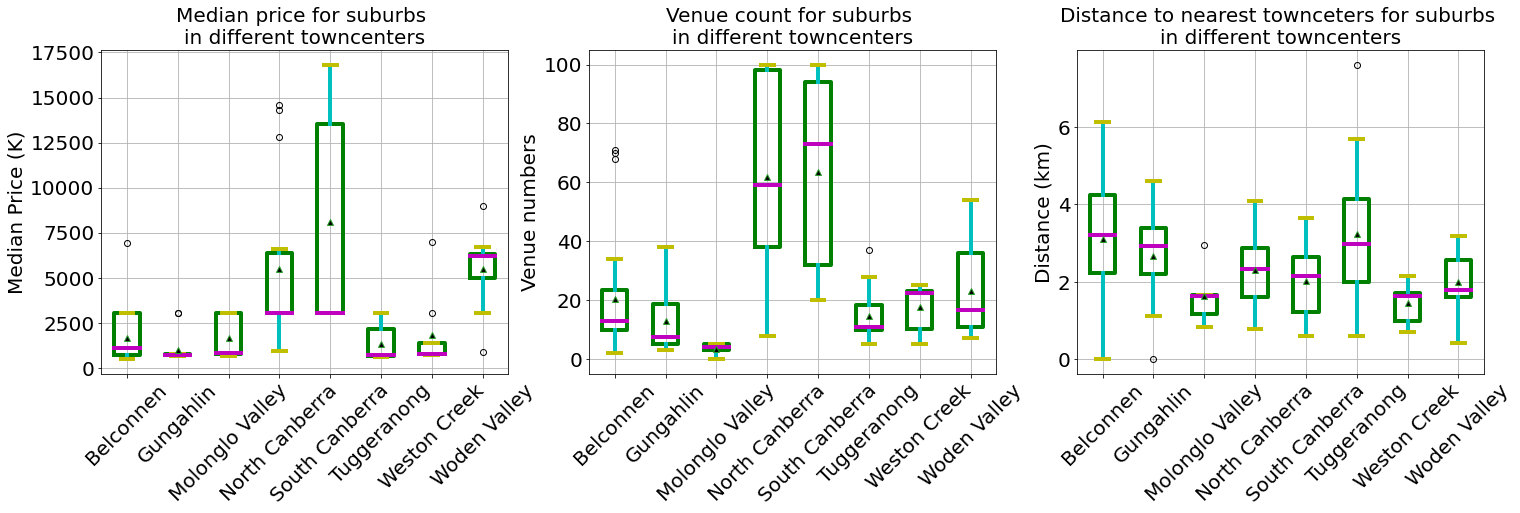

In [121]:
boxprops = dict(linestyle='-', linewidth=4, color='k')
medianprops = dict(linestyle='-', linewidth=4, color='k')

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))

bp1 = df_can.boxplot(column='Median Price',by='Towncenter', ax=ax1,
                    showfliers=True, showmeans=True,
                    boxprops=boxprops, medianprops=medianprops,
                    return_type='dict')

bp2 = df_can.boxplot(column='venue count',by='Towncenter', ax=ax2,
                    showfliers=True, showmeans=True,
                    boxprops=boxprops, medianprops=medianprops,
                    return_type='dict')

bp3 = df_can.boxplot(column='Nearest',by='Towncenter', ax=ax3,
                    showfliers=True, showmeans=True,
                    boxprops=boxprops, medianprops=medianprops,
                    return_type='dict')

# boxplot style adjustments
adjust_boxplot_style(bp1)
adjust_boxplot_style(bp2)
adjust_boxplot_style(bp3)

# get rid of "boxplot grouped by" title
plt.suptitle("")

# label adjustment
ax1.set_title("Median price for suburbs \nin different towncenters", fontsize=20)
ax1.set_ylabel('Median Price (K)', fontsize=20)
ax1.set_xlabel('')
ax1.tick_params(axis='y', labelsize=20)
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis="x", rotation=45)

ax2.set_title("Venue count for suburbs \nin different towncenters", fontsize=20)
ax2.set_ylabel('Venue numbers', fontsize=20)
ax2.set_xlabel('')
ax2.tick_params(axis='y', labelsize=20)
ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis="x", rotation=45)

ax3.set_title("Distance to nearest townceters for suburbs \nin different towncenters", fontsize=20)
ax3.set_ylabel('Distance (km)', fontsize=20)
ax3.set_xlabel('')
ax3.tick_params(axis='y', labelsize=20)
ax3.tick_params(axis='x', labelsize=20)
ax3.tick_params(axis="x", rotation=45)

From the above 3 plots, we can see that there are more venues in North and South Canberras and the house price there are also much higher than suburbs in other towncenters. The distance for suburbs to closed towncenter however does not present a significant difference which indicate the well planned geo structure of Canberra suburbs. Next we will use k-means to cluster all the suburbs.

### k-means clustering on master dataset

In this section, we will use k-means to perform unsupervised clustering on our master dataset `df_can` and the venue category dataset `df_venues`. To find the optimal number of clusters, the elbow method will be used.

In [66]:
#df_can = pd.read_csv('data/canberra_suburbs_venues.csv')
drop_columns = ['Towncenter', 'Postcode', 'Latitude', 'Longitude']
df_cluster = df_can.drop(drop_columns, axis=1).set_index('Suburb')
df_cluster.head()

,Nearest,Median Price,venue count
Suburb,,,
Acton,2.921057,3044.733334,100.0
Ainslie,1.413531,14295.000000,61.0
Amaroo,1.106799,726.000000,38.0
Aranda,4.783948,3044.733334,29.0
Banks,5.702031,655.000000,9.0


In [67]:
# normalize datasets
from sklearn.preprocessing import StandardScaler
X = df.values[:,:]
X = np.nan_to_num(X)
clus_data = StandardScaler().fit_transform(X)
clus_data.shape

(112, 3)

To find optimal cluster number, we iterate from 1 to 10 and find the turning point:

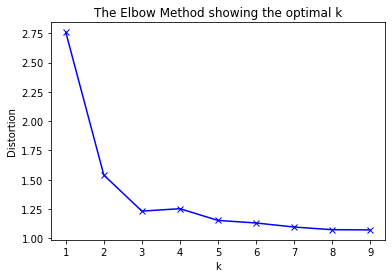

In [68]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=0).fit(clus_data)
    distortions.append(sum(np.min(cdist(clus_data, kmeanModel.cluster_centers_, 'canberra'), axis=1)) / clus_data.shape[0])

#There are different metric distance function for spatial distance. 
#I choose correlation instaed of euclidean because the canberra function gives me more clear view of elbow break point.

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

So 3 would be the optimal number of clusters and let's rerun the clustering:

In [105]:
# set number of clusters
kclusters = 3
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(clus_data)
kmeans.labels_

array([1, 1, 0, 2, 2, 1, 0, 2, 0, 1, 2, 0, 1, 1, 2, 0, 2, 1, 2, 1, 2, 2,
       0, 2, 2, 1, 0, 1, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 1, 2, 2, 2, 1, 2,
       2, 2, 0, 0, 1, 0, 2, 2, 0, 0, 0, 2, 1, 2, 2, 0, 2, 2, 2, 1, 0, 2,
       0, 1, 2, 2, 2, 1, 0, 2, 0, 2, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 2, 0, 2, 2, 2, 2, 0, 1, 0, 0, 2, 1, 0, 2,
       0, 1], dtype=int32)

In [107]:
# insert the cluster label to DataFrame
df_cluster = df_can.copy()
df_cluster.insert(0, 'Cluster', kmeans.labels_)
df_cluster.reset_index()
df_cluster.head()

,Cluster,Suburb,Towncenter,Postcode,Latitude,Longitude,Nearest,Median Price,venue count
0,1,Acton,North Canberra,2601,-35.285232,149.112968,2.921057,3044.733334,100.0
1,1,Ainslie,North Canberra,2602,-35.262195,149.147880,1.413531,14295.000000,61.0
2,0,Amaroo,Gungahlin,2914,-35.169587,149.128021,1.106799,726.000000,38.0
3,2,Aranda,Belconnen,2614,-35.258055,149.080426,4.783948,3044.733334,29.0
4,2,Banks,Tuggeranong,2906,-35.471889,149.099657,5.702031,655.000000,9.0


In [108]:
df_cluster['Cluster'].value_counts()

2    42
0    42
1    28
Name: Cluster, dtype: int64

#### Revisit statistics on clustered suburbs

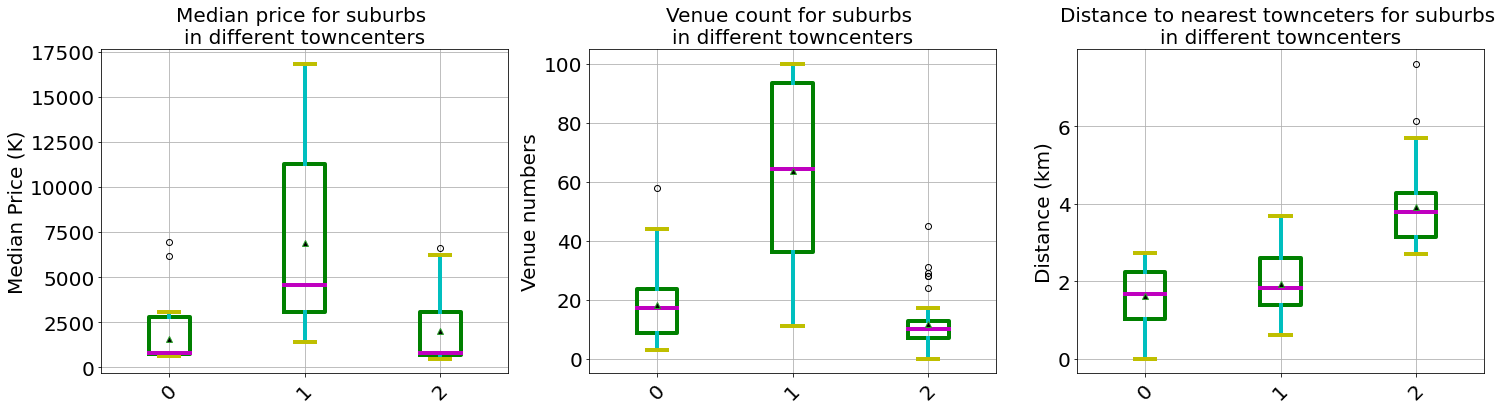

In [122]:
boxprops = dict(linestyle='-', linewidth=4, color='k')
medianprops = dict(linestyle='-', linewidth=4, color='k')

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))

bp1 = df_cluster.boxplot(column='Median Price',by='Cluster', ax=ax1,
                    showfliers=True, showmeans=True,
                    boxprops=boxprops, medianprops=medianprops,
                    return_type='dict')

bp2 = df_cluster.boxplot(column='venue count',by='Cluster', ax=ax2,
                    showfliers=True, showmeans=True,
                    boxprops=boxprops, medianprops=medianprops,
                    return_type='dict')

bp3 = df_cluster.boxplot(column='Nearest',by='Cluster', ax=ax3,
                    showfliers=True, showmeans=True,
                    boxprops=boxprops, medianprops=medianprops,
                    return_type='dict')

# boxplot style adjustments
adjust_boxplot_style(bp1)
adjust_boxplot_style(bp2)
adjust_boxplot_style(bp3)

# get rid of "boxplot grouped by" title
plt.suptitle("")

# label adjustment
ax1.set_title("Median price for suburbs \nin different towncenters", fontsize=20)
ax1.set_ylabel('Median Price (K)', fontsize=20)
ax1.set_xlabel('')
ax1.tick_params(axis='y', labelsize=20)
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis="x", rotation=45)

ax2.set_title("Venue count for suburbs \nin different towncenters", fontsize=20)
ax2.set_ylabel('Venue numbers', fontsize=20)
ax2.set_xlabel('')
ax2.tick_params(axis='y', labelsize=20)
ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis="x", rotation=45)

ax3.set_title("Distance to nearest townceters for suburbs \nin different towncenters", fontsize=20)
ax3.set_ylabel('Distance (km)', fontsize=20)
ax3.set_xlabel('')
ax3.tick_params(axis='y', labelsize=20)
ax3.tick_params(axis='x', labelsize=20)
ax3.tick_params(axis="x", rotation=45)

Now let's create a Folium map and add the clusterd suburbs together with towncenters. It is clear that suburbs in North and South Canberra have been segmented into one category as these suburnbs. The other category are those very close to town centers while the rest suburbs make up the last category.

In [77]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_cluster['Latitude'], df_cluster['Longitude'], df_cluster['Suburb'], df_cluster['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
    
# add markers to towncenters
for lat, lng, towncenter in zip(df_town['Latitude'], df_town['Longitude'], df_town['Towncenter']):
    label = '{}'.format(towncenter)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=30,
        popup=label,
        color='purple',
        fill=True,
        fill_color='#EDE3FF',
        fill_opacity=0.3,
        parse_html=False).add_to(map_clusters)
       
map_clusters

### k-means clustering on venue category dataset

Let use k-means to cluster the suburbs based on the venue category information in each suburb now. First find optimal number of cluster:

In [86]:
# canberra_venues = pd.read_csv('data/canberra_venues.csv')
canberra_venues.head()

# one hot encoding
canberra_onehot = pd.get_dummies(canberra_venues[['Venue Category']], prefix="", prefix_sep="")

# add suburb column back to dataframe
canberra_onehot['Suburb'] = canberra_venues['Suburb'] 

# move Suburb column to the first column
list_column = canberra_onehot.columns.tolist()
number_column = int(list_column.index('Suburb'))
list_column = [list_column[number_column]] + list_column[:number_column] + list_column[number_column+1:] 
canberra_onehot = canberra_onehot[list_column]

canberra_onehot.head()

,Suburb,Animal Shelter,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Bavarian Restaurant,Beach,Beer Bar,Bistro,Bookstore,Botanical Garden,Bowling Alley,Brewery,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Bus Station,Bus Stop,Business Service,Café,Campground,Cantonese Restaurant,Child Care Service,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cricket Ground,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Doner Restaurant,Donut Shop,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Exhibit,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Food & Drink Shop,Food Court,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,Gift Shop,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Historic Site,History Museum,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Juice Bar,Kebab Restaurant,Korean Restaurant,Lake,Lawyer,Lebanese Restaurant,Library,Light Rail Station,Lighting Store,Liquor Store,Lounge,Malay Restaurant,Market,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Mountain,Multiplex,Museum,Music Venue,Nature Preserve,Newsstand,Noodle House,Organic Grocery,Outdoor Sculpture,Outdoor Supply Store,Paintball Field,Paper / Office Supplies Store,Park,Parking,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Pool,Post Office,Pub,Public Art,RV Park,Racecourse,Restaurant,Rooftop Bar,Rugby Pitch,Salad Place,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Shipping Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Soccer Field,Social Club,South Indian Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Supermarket,Sushi Restaurant,Szechuan Restaurant,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tiki Bar,Tourist Information Center,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Veterinarian,Vietnamese Restaurant,Volleyball Court,Water Park,Waterfront,Whisky Bar,Wine Bar,Winery,Women's Store,Yoga Studio,Zoo
0,Acton,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Acton,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Acton,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Acton,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

Now let's group rows by suburb and by taking the mean of the frequency of occurrence of each category:

In [88]:
canberra_grouped = canberra_onehot.groupby('Suburb').mean().reset_index()
canberra_grouped.head()

,Suburb,Animal Shelter,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Bavarian Restaurant,Beach,Beer Bar,Bistro,Bookstore,Botanical Garden,Bowling Alley,Brewery,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Bus Station,Bus Stop,Business Service,Café,Campground,Cantonese Restaurant,Child Care Service,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cricket Ground,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Doner Restaurant,Donut Shop,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Exhibit,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Food & Drink Shop,Food Court,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,Gift Shop,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Historic Site,History Museum,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Juice Bar,Kebab Restaurant,Korean Restaurant,Lake,Lawyer,Lebanese Restaurant,Library,Light Rail Station,Lighting Store,Liquor Store,Lounge,Malay Restaurant,Market,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Mountain,Multiplex,Museum,Music Venue,Nature Preserve,Newsstand,Noodle House,Organic Grocery,Outdoor Sculpture,Outdoor Supply Store,Paintball Field,Paper / Office Supplies Store,Park,Parking,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Pool,Post Office,Pub,Public Art,RV Park,Racecourse,Restaurant,Rooftop Bar,Rugby Pitch,Salad Place,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Shipping Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Soccer Field,Social Club,South Indian Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Supermarket,Sushi Restaurant,Szechuan Restaurant,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tiki Bar,Tourist Information Center,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Veterinarian,Vietnamese Restaurant,Volleyball Court,Water Park,Waterfront,Whisky Bar,Wine Bar,Winery,Women's Store,Yoga Studio,Zoo
0,Acton,0.0,0.0,0.0,0.010000,0.0,0.010000,0.000000,0.0,0.010000,0.0,0.0,0.0,0.0,0.0,0.01,0.000000,0.010000,0.01,0.0,0.000000,0.0,0.0,0.0,0.0,0.020000,0.0,0.0,0.000000,0.080000,0.0,0.0,0.0,0.020000,0.01,0.0,0.0,0.01,0.060000,0.01,0.01,0.0,0.000000,0.0,0.0,0.0,0.010000,0.0,0.01,0.0,0.0,0.0,0.000000,0.000000,0.01,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.010000,0.0,0.01,0.01,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.010000,0.010000,0.0,0.000000,0.0,0.02,0.01,0.070000,0.01,0.0,0.000000,0.010000,0.01,0.0,0.01,0.040000,0.030000,0.0,0.0,0.010000,0.000000,0.0,0.0,0.01,0.0,0.0,0.000000,0.01,0.0,0.000000,0.000000,0.0,0.0,0.040000,0.0,0.000000,0.000000,0.01,0.0,0.000000,0.01,0.0,0.01,0.000000,0.000000,0.020000,0.0,0.000000,0.0,0.0,0.0,0.02,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.02,0.010000,0.0,0.000000,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.020000,0.000000,0.0,0.0,0.0,0.010000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.01,0.0,0.0,0.010000,0.01,0.020000,0.01,0.01,0.01,0.0,0.030000,0.01,0.01,0.000000,0.01,0.01,0.010000,0.000000,0.0,0.000000,0.000000,0.0,0.020000,0.0,0.000000,0.0,0.01,0.02,0.0,0.0,0.0,0.0
1,Ainslie,0.0,0.0,0.0,0.049180,0.0,0.032787,0.016393,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00,0.016

Run through different k values:

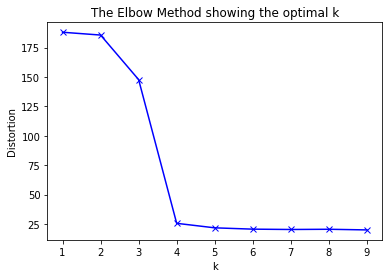

In [89]:
canberra_grouped_clustering = canberra_grouped.drop('Suburb', 1)

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=0).fit(canberra_grouped_clustering)
    distortions.append(sum(np.min(cdist(canberra_grouped_clustering, kmeanModel.cluster_centers_, 'canberra'), axis=1)) / canberra_grouped_clustering.shape[0])

#There are different metric distance function for spatial distance. 
#I choose correlation instaed of euclidean because the canberra function gives me more clear view of elbow break point.

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Use optimal number 4 to rerun the k-means clustering:

In [98]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(canberra_grouped_clustering)

# check cluster labels generated for each row in the dataframe
labels = kmeans.labels_
df_venues['Cluster'] = labels
df_venues.head()

,Suburb,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster
0,Acton,Café,Hotel,Coffee Shop,Mexican Restaurant,Italian Restaurant,Thai Restaurant,Japanese Restaurant,Sandwich Place,Plaza,Noodle House,3
1,Ainslie,Café,Hotel,Chinese Restaurant,Liquor Store,Asian Restaurant,Grocery Store,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Coffee Shop,Australian Restaurant,3
2,Amaroo,Café,Fast Food Restaurant,Supermarket,Shopping Plaza,Department Store,Sandwich Place,Social Club,Mobile Phone Shop,Shopping Mall,Coffee Shop,3
3,Aranda,Gym,Café,Supermarket,Hotel,Chinese Restaurant,Bookstore,Liquor Store,Gas Station,Market,Sports Club,3
4,Banks,Supermarket,Sandwich Place,Fried Chicken Joint,Bistro,Toy / Game Store,Fast Food Restaurant,Grocery Store,Pizza Place,Ethiopian Restaurant,Fish & Chips Shop,2


In [99]:
df_venues_merged = pd.merge(df_can, df_venues, left_on='Suburb', right_on='Suburb', how='inner')
df_venues_merged.head()

,Suburb,Towncenter,Postcode,Latitude,Longitude,Nearest,Median Price,venue count,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster
0,Acton,North Canberra,2601,-35.285232,149.112968,2.921057,3044.733334,100.0,Café,Hotel,Coffee Shop,Mexican Restaurant,Italian Restaurant,Thai Restaurant,Japanese Restaurant,Sandwich Place,Plaza,Noodle House,3
1,Ainslie,North Canberra,2602,-35.262195,149.147880,1.413531,14295.000000,61.0,Café,Hotel,Chinese Restaurant,Liquor Store,Asian Restaurant,Grocery Store,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Coffee Shop,Australian Restaurant,3
2,Amaroo,Gungahlin,2914,-35.169587,149.128021,1.106799,726.000000,38.0,Café,Fast Food Restaurant,Supermarket,Shopping Plaza,Department Store,Sandwich Place,Social Club,Mobile Phone Shop,Shopping Mall,Coffee Shop,3
3,Aranda,Belconnen,2614,-35.258055,149.080426,4.783948,3044.733334,29.0,Gym,Café,Supermarket,Hotel,Chinese Restaurant,Bookstore,Liquor Store,Gas Station,Market,Sports Club,3
4,Banks,Tuggeranong,2906,-35.471889,149.099657,5.702031,655.000000,9.0,Supermarket,Sandwich Place,Fried Chicken Joint,Bistro,Toy / Game Store,Fast Food Restaurant,Grocery Store,Pizza Place,Ethiopian Restaurant,Fish & Chips Shop,2


Now let's create a Folium map and use cluster labels from venue categories:

In [101]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_venues_merged['Latitude'], df_venues_merged['Longitude'], df_venues_merged['Suburb'], df_venues_merged['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
    
# add markers to towncenters
for lat, lng, towncenter in zip(df_town['Latitude'], df_town['Longitude'], df_town['Towncenter']):
    label = '{}'.format(towncenter)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=30,
        popup=label,
        color='purple',
        fill=True,
        fill_color='#EDE3FF',
        fill_opacity=0.3,
        parse_html=False).add_to(map_clusters)
       
map_clusters

## Results and Discussion <a name="results"></a>

Using the main dataset, most cluster 1 suburbs are located at the inner north or south Canberra. While these suburbs are well established with various venues, their price are also much higher than other suburbs. Suburbs in cluster 2 have the lowest price, but meanwhile they also do not have as many venues and the travel distance to town centers are higher. Cluster 0 suburbs seem to have the best balance for all three factors and not superisingly they are located around other town centers apart from the North and South Canberra.

Clustering results using venue category information are even more interesting: suburbs in North and South Canberra (together with Tuggeranoon) again are clustered into one segment while suburbs in other north towns (Belconnen and Gungahlin) are segmented together. Suburbs in Woden and Westen Creek share some similarities unlike other towns. These difference might very well becasue of the developmnet shift from South Canberra to North Canberras. Due to the scope of the study, we will not furth explore the behind reasons.

Based on the above analysis, hopefully our young family should now have more information to refere to when they finnaly decide which suburb to settle in.

## Conclusion <a name="conclusion"></a>

In this study, various techniques varing from webscraping to open dataset have been used to collect data related to Canberra suburbs. Unsupervised k-means clustering algorithms have been applied to two assembed datasets: one master dataset consisting of median house price, number of venues and closest distance to nearby towncenters; while the second dataset includes venue category information around each suburb.

As per the decision to choose which suburb to live in, certainly more factors should be considered, e.g. local schools, developing trend. They are not included in this study due to the limited time and the already lengthy contet, but definitely will be helpful to provide an even accurate and detailed suburb segmentation.

Source of this capstone project [can be found on my Github](https://github.com/fanpeng-kong/Coursera_Capstone).